# Assimilation of ICESat-2 data with VIIRS/MODIS-Aqua

In [3]:
import icepyx as ipx

from pathlib import Path
import h5py
import os
import numpy as np
import pandas as pd
import pyproj
import pickle
from shapely import geometry
from shapely.ops import unary_union

from astropy.time import Time
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree

plt.rcParams['figure.figsize'] = [15, 10]

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from utils import get_file_in_directory, time_from_TAI93, drainage_basin
from utils_atl06 import read_atl06
from utils_cloud import associate, image_convexHull 

In [6]:
!ls

Assimilation.ipynb		      mixed_graphical_model.Rmd
Climate_bash.ipynb		      MODIS-VIIRS-time-discrepancies.ipynb
CloudMask.ipynb			      my_polygon
data				      __pycache__
dict_VIIRS_2_ATL06_dt15_parallel.pkl  README.md
dict_VIIRS_2_ATL06_dt15.pkl	      scan-time-issue
dict_VIIRS_2_ATL06_dt20_full.pkl      svm_conf.png
dict_VIIRS_2_ATL06_dt5.pkl	      svm_conf.svg
drainage_basin			      utils_atl03.py
Example-MODIS+VIIRS.ipynb	      utils_atl06.py
examples			      utils_cloud.py
icepyx_checks			      utils.py
LICENSE				      viz
mixed_graphical_model.ipynb


### General parameters

In [7]:
# Number of VIIRS/MODIS images to be randomly processed
M = 100
np.random.seed(606)

# Window in hours to retrieve ICESat-2 data around VIIRS image
minutes = 5
hr = minutes / 60

# Number of nearest neighbours to consider for the assimilation
k = 10

# Distance in kilometers above which ICESat-2 measuraments will be discarted in case that there is no spatial match with VIIRS
tolerance_spatial_dismatch = 1

# Approximate radii of the Earth
radii = 6371

Cloud_variable = 'Integer_Cloud_Mask'

### Spatial Extent

In [8]:
basins_ids = [1.1, 1.2, 1.3, 1.4,
              2.1, 2.2, 
              3.1, 3.2, 3.3, 
              4.1, 4.2, 4.3,
              5.0,
              6.1, 6.2,
              7.1, 7.2, 
              8.1, 8.2]

my_basins = basins_ids
polygons = [drainage_basin(basin_id) for basin_id in my_basins ]
poly_full = unary_union(polygons)
polygon_Greenland = poly_full.simplify(tolerance=0.3)

#spatial_extent = list(poly_full_simplify.exterior.coords)

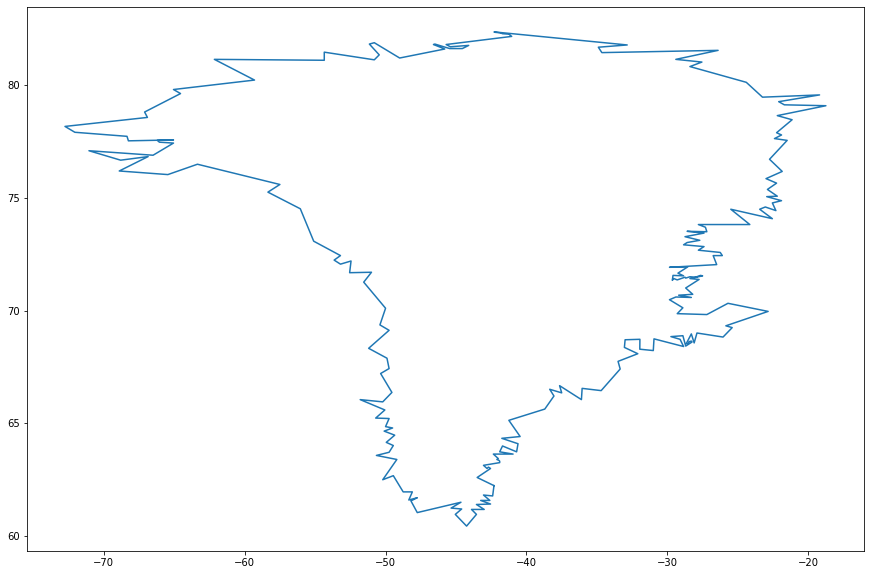

In [9]:
full_longitudes, full_latitudes =  poly_full.exterior.xy
Greenland_lon, Greenland_lat = polygon_Greenland.exterior.xy

#plt.plot(full_longitudes, full_latitudes)
plt.plot(Greenland_lon, Greenland_lat)

### Sensor specific parameters

In [10]:
sensor = 'VIIRS'
#sensor = 'MODIS'

if sensor == 'VIIRS':
    
    #number_scans = 203
    number_detectors = 16
    across_track = 3200
    #Cloud_file = 'data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019267.1448.001.2019268010420.nc'
    #along_track = number_scans * number_detectors
    #assert along_track == 3248

    # Directory where the VIIRS data is located
    path_data = 'data/VIIRS'
    # Directory where the ATL06 is located or should be downloaded 
    path_data_ATL06 = 'data/ATL06/Assimilation_VIIRS/'
    # Name of the pickle file where we download the dictonary data
    dict_save = "dict_VIIRS_2_ATL06_dt" + str(minutes)  + ".pkl"
    
if sensor == 'MODIS':
    
    #number_scans = 204
    number_detectors = 10
    across_track = 1354
    #Cloud_file = 'data/MODIS_Aqua/CLDMSK_L2_MODIS_Aqua.A2020139.1755.001.2020140163713.nc'
    #along_track = number_scans * number_detectors
    #assert along_track == 2040
    
    # Directory where the VIIRS data is located
    path_data = 'data/MODIS_Aqua'
    # Directory where the ATL06 is located or should be downloaded 
    path_data_ATL06 = 'data/ATL06/Assimilation_MODIS_Aqua/'
    # Name of the pickle file where we download the dictonary data
    dict_save = "dict_MODIS_2_ATL06_dt" + str(minutes)  + ".pkl"

Files to be processed

In [37]:
all_files = get_file_in_directory(path_data)

files = np.random.choice(all_files, M, replace = False)

# Assimilation

-
Name of VIIRS file: CLDMSK_L2_VIIRS_SNPP.A2019340.1200.001.2019341011149.nc
No granules for this specification
-
Name of VIIRS file: CLDMSK_L2_VIIRS_SNPP.A2019343.2300.001.2019344070144.nc


TopologyException: Input geom 0 is invalid: Hole lies outside shell at or near point -60.897195000000011 81.241118999999998 at -60.897195000000011 81.241118999999998


Convex Hull exception
Available Granules: ['ATL06_20191209230206_11310503_003_01.h5', 'ATL06_20191209230731_11310504_003_01.h5']
Total number of data order requests is  1  for  2  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000953038
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000953038 of  1  order(s) is downloaded.
Download complete
ATL06_20191209230731_11310504_003_01.h5 not found
You are missing some files. There are a total of 2 available granules but you are accessing 1 h5 files
>>>  data/ATL06/Assimilation_VIIRS/processed_ATL06_20191209230206_11310503_003_01.h5
--> Segments in file: (117993, 33)
--> Segments in file after temporal filer: (117993, 33)


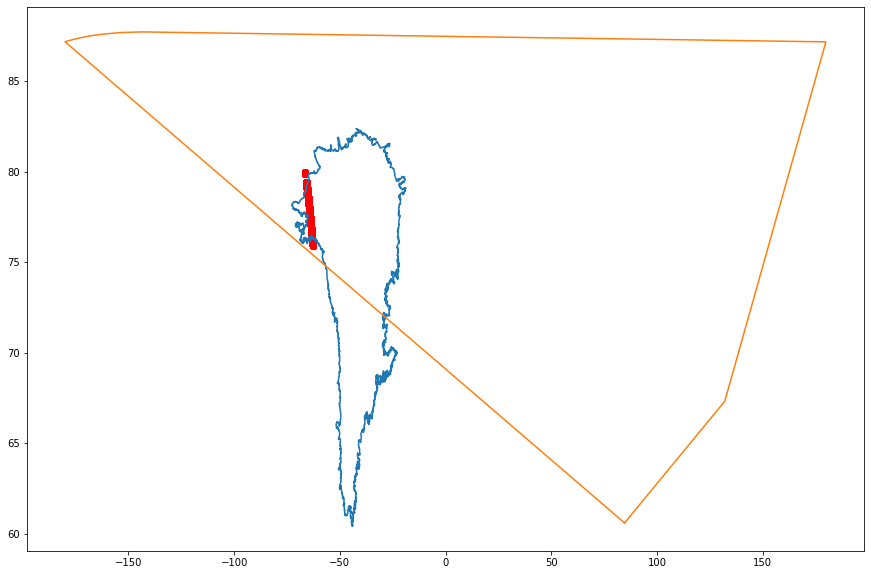

-
Name of VIIRS file: CLDMSK_L2_VIIRS_SNPP.A2019341.1000.001.2019341190232.nc
Available Granules: ['ATL06_20191207095014_10920504_003_01.h5', 'ATL06_20191207095523_10920505_003_01.h5']
Total number of data order requests is  1  for  2  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000953039
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000000953039 

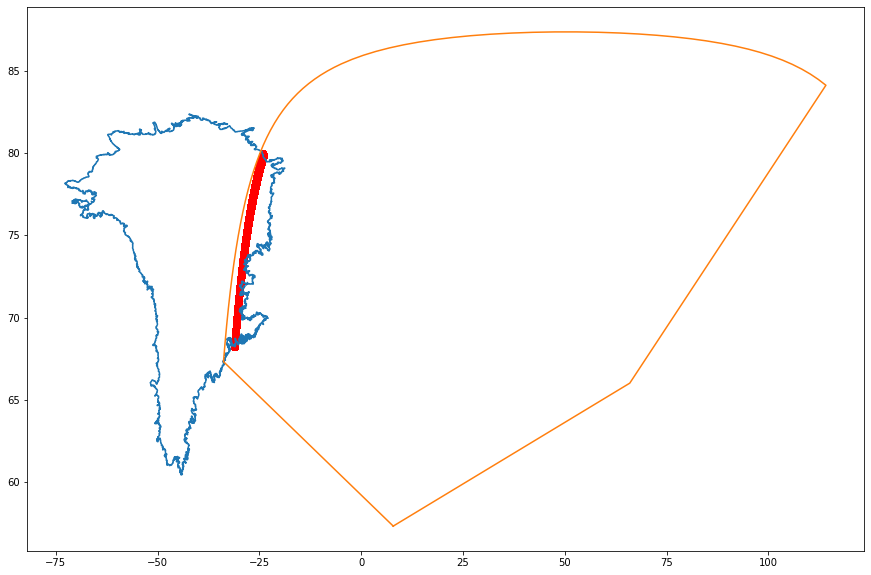

Process completed


In [49]:
files = get_file_in_directory(path_data)

CLDMSK_2_ATL06 = {}

for file in files:
    
    #try:
        
    file_name = file.split("/")[-1]
    print("-")
    print("Name of", sensor, "file:", file_name)

    #try:

    """
    Atmospheric product retrieval.

    For an example of how to read VIIRS or MODIS Aqua CLDMSK product, see Example-MODIS+VIIRS.ipynb

    This part should be return the same for all the external producs:

        - f_t: timestamp where the product was recorded
        - Lat : 2-dimensional np.array with the latitudes
        - Lon : 2-dimensional np.array with the longitudes
        - Mask : np.array with the label of the product

        - Time : 2-dimensional np.array with the time of the scan
        - t_initial: initial scanning time
        - t_fina: final scanning time

    """

    f_ = h5py.File(file, 'r')

    # Temportal properties
    f_t = f_['scan_line_attributes']['scan_start_time'][:]
    f_t = np.array([time_from_TAI93(t) for t in f_t])

    t_initial = f_t[0]
    t_final = f_t[-1]

    along_track = number_detectors * len(f_t)
    timeCLD = np.full((along_track, across_track), f_t[0])

    for i, t in enumerate(f_t):

        scan_time_array = np.full((number_detectors, across_track), t)
        timeCLD[(number_detectors * i): number_detectors * (i+1), :] = scan_time_array


    # Spatial properties
    lonCLD = f_["geolocation_data"]["longitude"][:]
    latCLD = f_["geolocation_data"]["latitude"][:]
    assert latCLD.shape == timeCLD.shape, "Time array and Latitude array must have the same shape"
    assert latCLD.shape == lonCLD.shape, "Latitude and Longitude must have the same shape"

    # Cloud mask
    maskCLD = f_['geophysical_data'][Cloud_variable][:]
    assert maskCLD.shape == latCLD.shape, "Cloud Mask and Latitude must have the same shape"


    """
    Preprocesing of the atmospheric product 
    """
    
    # Polygon that describes the product covering 
    cloud_contour = image_convexHull(lonCLD, latCLD)

    
    # I change the coordinates to radians and I stack pairs of (latitude, longitede) 

    #S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
    radCLD = np.vstack([latCLD[:].ravel(), lonCLD[:].ravel()]).T
    radCLD *= np.pi / 180.

    
    """
    ATL06 Retrieval
    """
    
    # Spatial extent
    # First, I check that there is intersection between Greenland and the image covering
    # Then, I select this intersections as spatial extent in order to retrieve ICESat-2 data.
    
    if polygon_Greenland.intersects(cloud_contour):
        try:
            Green_cloud_intersection = polygon_Greenland.intersection(cloud_contour)
        except:
            print("Convex Hull exception")
            Green_cloud_intersection = polygon_Greenland.convex_hull.intersection(cloud_contour)
            
        spatial_extent = list(Green_cloud_intersection.exterior.coords)
    else:
        continue
        

    # Temporal search window for 
    start = t_initial - pd.DateOffset(hours=hr)
    end   = t_final   + pd.DateOffset(hours=hr)

    start_date_str = start.strftime('%Y-%m-%d')
    end_date_str   = end.strftime('%Y-%m-%d')
    start_time_str = start.strftime('%H:%M:%S')
    end_time_str   = end.strftime('%H:%M:%S')

    date_range = [start_date_str, end_date_str]
    
    
    df = read_atl06(spatial_extent = spatial_extent,
                    date_range = date_range,
                    time_start = start_time_str,
                    time_end = end_time_str,
                    path = path_data_ATL06)
    
    if not type(df) == pd.core.frame.DataFrame:
        continue

    print("--> Segments in file:", df.shape)

    if df.shape[0] == 0:
        print("The retrieved dataframes has no entries.")
        continue

    lonATL = df.longitude.values
    latATL = df.latitude.values 

    #F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
    radATL = np.vstack([latATL[:].ravel(), lonATL[:].ravel()]).T
    radATL *= np.pi / 180.

    ### I check that I don't have segments outside of my temporal window
    #df_goodtime = df[ df['time'] > start ]
    #df_goodtime = df_goodtime[ df_goodtime['time'] < end]
    #assert df.shape == df_goodtime.shape, "There are segments outside the specified temporal window"

    
    """
    Assimilation
    """

    # Label Assimilation

    distances, indices = associate(radCLD, radATL, k_nn=k)

    for i in range(indices.shape[1]):

        new_column = maskCLD.ravel()[indices[:, i]]

        if i == 0:
            col_name = Cloud_variable
        else:
            col_name = Cloud_variable + "_k" + str(i + 1)

        df[ col_name ] = new_column
        df[ col_name + "_dist" ] = distances[:, i]


    # Difference on time assimilation 
    df[ 'time_CLDMSK' ] = timeCLD.ravel()[indices[:, 0]]
    df[ 'delta_assim' ] = abs(df.time - df.time_CLDMSK) / np.timedelta64(1,'m')  

    # I filter points outside the temporal window 
    #df = df[ df["delta_assim"] < 60 * hr ] 

    # I filter ATL points outside the VIIRS Image
    #df = df[ df[Cloud_variable + "_dist"] < tolerance_spatial_dismatch / radii ]

    #print("--> Segments in file after assimilation filter:", df.shape)

    # Add name of VIIRS file to the column of the dataframes
    df['CLDMSK_name'] = file_name 


    CLDMSK_2_ATL06[file] = df

    a_file = open(dict_save, "wb")
    pickle.dump(CLDMSK_2_ATL06, a_file)
    a_file.close()
    
    
    plt.close()
    plt.plot(full_longitudes, full_latitudes)
    cloud_contour_lon, cloud_contour_lat =  cloud_contour.exterior.xy
    plt.plot(cloud_contour_lon, cloud_contour_lat)
    
    plt.scatter(df.longitude, df.latitude, c = 'red')
    plt.show()

    #except:
    #    print("Error")
    
    
print("Process completed")

In [48]:
type(df) == pd.core.frame.DataFrame

True

In [25]:
polygon_Greenland.intersects(cloud_contour)

True

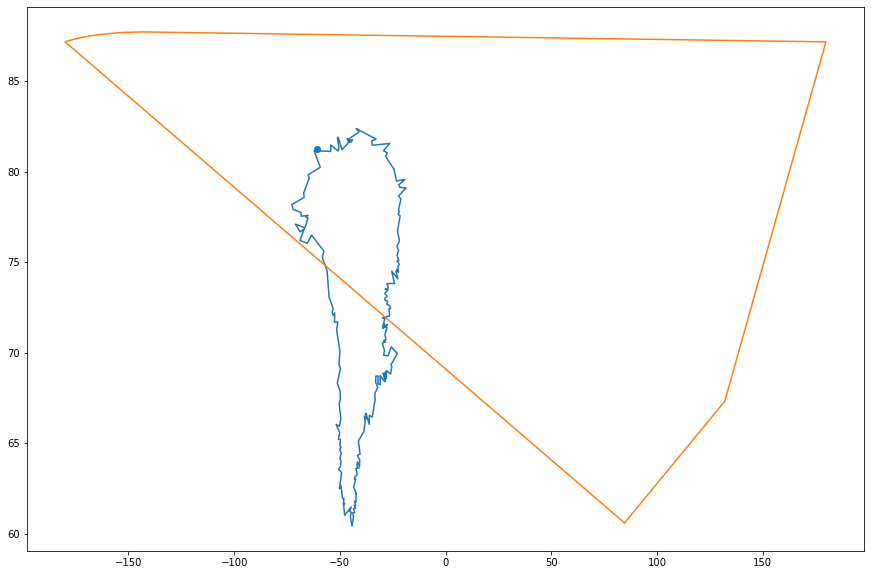

In [28]:
plt.plot(Greenland_lon, Greenland_lat)
cloud_contour_lon, cloud_contour_lat =  cloud_contour.exterior.xy
plt.plot(cloud_contour_lon, cloud_contour_lat)
plt.scatter(-60.897195000000011, 81.241118999999998)

In [17]:
type(polygon_Greenland)

shapely.geometry.polygon.Polygon

In [16]:
type(cloud_contour)

shapely.geometry.polygon.Polygon

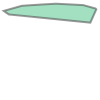

In [31]:
cloud_contour.intersection(polygon_Greenland.convex_hull)

In [14]:
Green_cloud_intersection = polygon_Greenland.intersection(cloud_contour)

TopologyException: Input geom 0 is invalid: Hole lies outside shell at or near point -60.897195000000011 81.241118999999998 at -60.897195000000011 81.241118999999998


TopologicalError: The operation 'GEOSIntersection_r' could not be performed. Likely cause is invalidity of the geometry <shapely.geometry.polygon.Polygon object at 0x2b02ab7792b0>

In [26]:
df.shape

(366076, 56)

In [37]:
Cloud_points = [(radCLD[i,1] * 180 / np.pi, radCLD[i,0] * 180 /np.pi) for i in range(radCLD.shape[0])]

In [38]:
Cloud_covering = geometry.MultiPoint(Cloud_points).convex_hull

KeyboardInterrupt: 

In [40]:
latCLD.shape
lonCLD.shape

(3232, 3200)

In [108]:
def image_convexHull (lonA, latA):
    """
    Given the longitude and latitude 2-dimensional arrays of a image, it returns a shapely polygon object
    corresponding to the convex hull of the image. 
    """
    
    assert lonA.shape == latA.shape
    
    N, M = lonA.shape
    
    contour_points = []
    
    for i in range(N): 
        contour_points.append( (lonA[i, 0], latA[i, 0]) )
        contour_points.append( (lonA[i, M-1], latA[i, M-1]) )
    for i in range(M):
        contour_points.append( (lonA[0, i], latA[0,i]) )
        contour_points.append( (lonA[N-1, i], latA[N-1, i]) )
        
    contour_points = [x for x in contour_points if ( ( -180 <= x[0] ) 
                                                   & ( x[0] <= 180 )
                                                   & ( -90 <= x[1] )
                                                   & ( x[1] <= 90) )]
    
    points = geometry.MultiPoint(contour_points)
    
    cloud_contour = points.convex_hull
    cloud_contour = cloud_contour.simplify(tolerance = 0.01)
    
    return cloud_contour

In [55]:
#points = geometry.MultiPoint( image_convexHull(lonCLD, latCLD) )

In [86]:
#cloud_contour = points.convex_hull
#cloud_contour = cloud_contour.simplify(tolerance = 0.01)

In [110]:
cloud_contour = image_convexHull(lonCLD, latCLD)
cloud_contour_lon, cloud_contour_lat =  cloud_contour.exterior.xy

In [111]:
len(Greenland_lat)

122

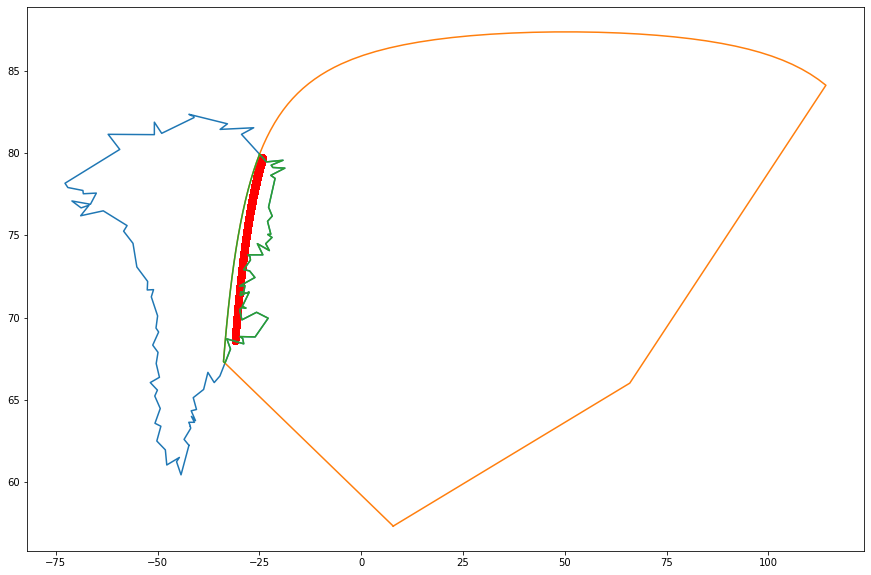

In [112]:
plt.close()
plt.plot(Greenland_lon, Greenland_lat)
plt.plot(cloud_contour_lon, cloud_contour_lat)
plt.plot([x[0] for x in spatial_extent], [x[1] for x in spatial_extent])
plt.scatter(df.longitude, df.latitude, c = 'red')
plt.show()

In [96]:
polygon_Greenland.intersects(cloud_contour)

True

In [97]:
Green_cloud_intersection = polygon_Greenland.intersection(cloud_contour)

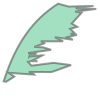

In [98]:
Green_cloud_intersection

In [99]:
spatial_extent = list(Green_cloud_intersection.exterior.coords)

In [101]:
len(spatial_extent)

68

## Parallel Assimilation

In [21]:
from joblib import Parallel, delayed

In [60]:
def cloud_ATL_2_df (file):

    try:
    
        """
        Atmospheric product retrieval.

        For an example of how to read VIIRS or MODIS Aqua CLDMSK product, see Example-MODIS+VIIRS.ipynb

        This part should be return the same for all the external producs:

            - f_t: timestamp where the product was recorded
            - Lat : 2-dimensional np.array with the latitudes
            - Lon : 2-dimensional np.array with the longitudes
            - Mask : np.array with the label of the product

            - Time : 2-dimensional np.array with the time of the scan
            - t_initial: initial scanning time
            - t_fina: final scanning time

        """

        f_ = h5py.File(file, 'r')
        file_name = file.split("/")[-1]

        # Temportal properties
        f_t = f_['scan_line_attributes']['scan_start_time'][:]
        f_t = np.array([time_from_TAI93(t) for t in f_t])

        t_initial = f_t[0]
        t_final = f_t[-1]


        along_track = number_detectors * len(f_t)
        timeCLD = np.full((along_track, across_track), f_t[0])

        for i, t in enumerate(f_t):

            scan_time_array = np.full((number_detectors, across_track), t)
            timeCLD[(number_detectors * i): number_detectors * (i+1), :] = scan_time_array


        # Spatial properties
        lonCLD = f_["geolocation_data"]["longitude"][:]
        latCLD = f_["geolocation_data"]["latitude"][:]
        assert latCLD.shape == timeCLD.shape, "Time array and Latitude array must have the same shape"
        assert latCLD.shape == lonCLD.shape, "Latitude and Longitude must have the same shape"

        # Cloud mask
        maskCLD = f_['geophysical_data'][Cloud_variable][:]
        assert maskCLD.shape == latCLD.shape, "Cloud Mask and Latitude must have the same shape"

        """
        Preprocesing of the atmospheric product 
        """

        # I change the coordinates to radians and I stack pairs of (latitude, longitede) 

        #S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
        radCLD = np.vstack([latCLD[:].ravel(), lonCLD[:].ravel()]).T
        radCLD *= np.pi / 180.


        """
        ATL06 Retrieval
        """

        # Temporal search window for 
        start = t_initial - pd.DateOffset(hours=hr)
        end   = t_final   + pd.DateOffset(hours=hr)

        start_date_str = start.strftime('%Y-%m-%d')
        end_date_str   = end.strftime('%Y-%m-%d')
        start_time_str = start.strftime('%H:%M:%S')
        end_time_str   = end.strftime('%H:%M:%S')


        date_range = [start_date_str, end_date_str]

        df = read_atl06(spatial_extent = spatial_extent,
                        date_range = date_range,
                        time_start = start_time_str,
                        time_end = end_time_str,
                        path = path_data_ATL06)

        print("--> Segments in file:", df.shape)

        if df.shape[0] == 0:
            print("The retrieved dataframes has no entries.")
            return None

        lonATL = df.longitude.values
        latATL = df.latitude.values 

        #F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
        radATL = np.vstack([latATL[:].ravel(), lonATL[:].ravel()]).T
        radATL *= np.pi / 180.

        ### I check that I don't have segments outside of my temporal window
        #df_goodtime = df[ df['time'] > start ]
        #df_goodtime = df_goodtime[ df_goodtime['time'] < end]
        #assert df.shape == df_goodtime.shape, "There are segments outside the specified temporal window"

        print("--> Segments in file after temporal filer:", df.shape)

        """
        Assimilation
        """

        # Label Assimilation

        distances, indices = associate(radCLD, radATL, k_nn=k)

        for i in range(indices.shape[1]):

            new_column = maskCLD.ravel()[indices[:, i]]

            if i == 0:
                col_name = Cloud_variable
            else:
                col_name = Cloud_variable + "_k" + str(i + 1)

            df[ col_name ] = new_column
            df[ col_name + "_dist" ] = distances[:, i]


        # Difference on time assimilation 
        df[ 'time_CLDMSK' ] = timeCLD.ravel()[indices[:, 0]]
        df[ 'delta_assim' ] = abs(df.time - df.time_CLDMSK) / np.timedelta64(1,'m')  

        # I filter points outside the temporal window 
        df = df[ df["delta_assim"] < 60 * hr ] 

        # I filter ATL points outside the VIIRS Image
        df = df[ df[Cloud_variable + "_dist"] < tolerance_spatial_dismatch / radii ]

        print("--> Segments in file after assimilation filter:", df.shape)

        # Add name of VIIRS file to the column of the dataframes
        df['CLDMSK_name'] = file_name 

        return df
    
    except:
        return None

In [70]:
files = get_file_in_directory(path_data)
#files = [file.split("/")[-1] for file in files]

In [ ]:
res = Parallel(n_jobs = -3)(delayed(cloud_ATL_2_df)(file) for file in files)

In [78]:
CLDMSK_2_ATL06 = {}

for i, file in enumerate(files):
    file_name = file.split("/")[-1]
    CLDMSK_2_ATL06[file_name] = res[i]

In [79]:
a_file = open(dict_save, "wb")
pickle.dump(CLDMSK_2_ATL06, a_file)
a_file.close()

In [ ]:
infile = open('dict_VIIRS_2_ATL06_dt15.pkl','rb')

CLDMSK_2_ATL06 = pickle.load(infile)
infile.close()

In [90]:
count

159

In [91]:
count = 0

for cld in CLDMSK_2_ATL06.keys():
    if type(CLDMSK_2_ATL06[cld]) == pd.core.frame.DataFrame:
        count += 1
        print(CLDMSK_2_ATL06[cld].shape)

(130899, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(34695, 46)
(0, 46)
(0, 46)
(64722, 46)
(0, 46)
(0, 46)
(0, 46)
(73014, 46)
(129911, 46)
(0, 46)
(32901, 46)
(0, 46)
(126573, 46)
(0, 46)
(132979, 46)
(0, 46)
(46557, 46)
(0, 46)
(31560, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(17903, 46)
(0, 46)
(0, 46)
(44314, 46)
(0, 46)
(0, 46)
(23920, 46)
(28030, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(85575, 46)
(0, 46)
(166, 46)
(0, 46)
(0, 46)
(138655, 46)
(0, 46)
(4450, 46)
(588, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(73574, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(29790, 46)
(0, 46)
(0, 46)
(0, 46)
(63053, 46)
(44438, 46)
(0, 46)
(22501, 46)
(24520, 46)
(508, 46)
(0, 46)
(0, 46)
(18301, 46)
(171, 46)
(15246, 46)
(0, 46)
(0, 46)
(123264, 46)
(0, 46)
(0, 46)
(57440, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(0, 46)
(113041, 46)
(2876, 46)
(0, 46)
(49860, 46)
(0, 46)
(0, 46)
(0, 46)
(18721, 46)
(32885,

In [53]:
def suma(x):
    return sum(range(1000000))

In [54]:
%time suma(1)

CPU times: user 11.4 ms, sys: 0 ns, total: 11.4 ms
Wall time: 11.4 ms


499999500000

In [56]:
%time [suma(x) for x in range(100)];

CPU times: user 1.14 s, sys: 1.03 ms, total: 1.14 s
Wall time: 1.14 s


[499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500

In [65]:
%time Parallel(n_jobs = 10)(delayed(suma)(x) for x in range(100))

CPU times: user 51.8 ms, sys: 53.5 ms, total: 105 ms
Wall time: 2.97 s


[499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500000,
 499999500

### Diagnosis

In [28]:
# files = ["data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019352.1000.001.2019352190736.nc"]  404 error
# files = ["data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019232.1542.001.2019233010838.nc"]  404 error
files = ["data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019052.1206.001.2019060175001.nc"]

CLDMSK_2_ATL06 = {}

for file in files:
    
    #try:
        
    file_name = file.split("/")[-1]
    print("-")
    print("Name of", sensor, "file:", file_name)

    #try:

    """
    Atmospheric product retrieval.

    For an example of how to read VIIRS or MODIS Aqua CLDMSK product, see Example-MODIS+VIIRS.ipynb

    This part should be return the same for all the external producs:

        - f_t: timestamp where the product was recorded
        - Lat : 2-dimensional np.array with the latitudes
        - Lon : 2-dimensional np.array with the longitudes
        - Mask : np.array with the label of the product

        - Time : 2-dimensional np.array with the time of the scan
        - t_initial: initial scanning time
        - t_fina: final scanning time

    """

    f_ = h5py.File(file, 'r')

    # Temportal properties
    f_t = f_['scan_line_attributes']['scan_start_time'][:]
    f_t = np.array([time_from_TAI93(t) for t in f_t])

    t_initial = f_t[0]
    t_final = f_t[-1]

    along_track = number_detectors * len(f_t)
    timeCLD = np.full((along_track, across_track), f_t[0])

    for i, t in enumerate(f_t):

        scan_time_array = np.full((number_detectors, across_track), t)
        timeCLD[(number_detectors * i): number_detectors * (i+1), :] = scan_time_array


    # Spatial properties
    lonCLD = f_["geolocation_data"]["longitude"][:]
    latCLD = f_["geolocation_data"]["latitude"][:]
    assert latCLD.shape == timeCLD.shape, "Time array and Latitude array must have the same shape"
    assert latCLD.shape == lonCLD.shape, "Latitude and Longitude must have the same shape"

    # Cloud mask
    maskCLD = f_['geophysical_data'][Cloud_variable][:]
    assert maskCLD.shape == latCLD.shape, "Cloud Mask and Latitude must have the same shape"


    """
    Preprocesing of the atmospheric product 
    """

    # I change the coordinates to radians and I stack pairs of (latitude, longitede) 

    #S_rad = np.vstack([lonS[:].ravel(),latS[:].ravel()]).T
    radCLD = np.vstack([latCLD[:].ravel(), lonCLD[:].ravel()]).T
    radCLD *= np.pi / 180.


    """
    ATL06 Retrieval
    """

    # Temporal search window for 
    start = t_initial - pd.DateOffset(hours=hr)
    end   = t_final   + pd.DateOffset(hours=hr)

    start_date_str = start.strftime('%Y-%m-%d')
    end_date_str   = end.strftime('%Y-%m-%d')
    start_time_str = start.strftime('%H:%M:%S')
    end_time_str   = end.strftime('%H:%M:%S')


    date_range = [start_date_str, end_date_str]

    df = read_atl06(spatial_extent = spatial_extent,
                    date_range = date_range,
                    time_start = start_time_str,
                    time_end = end_time_str,
                    path = path_data_ATL06)

    print("--> Segments in file:", df.shape)

    if df.shape[0] == 0:
        print("The retrieved dataframes has no entries.")
        continue

    lonATL = df.longitude.values
    latATL = df.latitude.values 

    #F_rad = np.vstack([lonF[:].ravel(),latF[:].ravel()]).T
    radATL = np.vstack([latATL[:].ravel(), lonATL[:].ravel()]).T
    radATL *= np.pi / 180.

    ### I check that I don't have segments outside of my temporal window
    #df_goodtime = df[ df['time'] > start ]
    #df_goodtime = df_goodtime[ df_goodtime['time'] < end]
    #assert df.shape == df_goodtime.shape, "There are segments outside the specified temporal window"

    print("--> Segments in file after temporal filer:", df.shape)

    """
    Assimilation
    """

    # Label Assimilation

    distances, indices = associate(radCLD, radATL, k_nn=k)

    for i in range(indices.shape[1]):

        new_column = maskCLD.ravel()[indices[:, i]]

        if i == 0:
            col_name = Cloud_variable
        else:
            col_name = Cloud_variable + "_k" + str(i + 1)

        df[ col_name ] = new_column
        df[ col_name + "_dist" ] = distances[:, i]


    # Difference on time assimilation 
    df[ 'time_CLDMSK' ] = timeCLD.ravel()[indices[:, 0]]
    df[ 'delta_assim' ] = abs(df.time - df.time_CLDMSK) / np.timedelta64(1,'m')  

    break

    # I filter points outside the temporal window 
    df = df[ df["delta_assim"] < 60 * hr ] 

    # I filter ATL points outside the VIIRS Image
    df = df[ df[Cloud_variable + "_dist"] < tolerance_spatial_dismatch / radii ]

    print("--> Segments in file after assimilation filter:", df.shape)

    # Add name of VIIRS file to the column of the dataframes
    df['CLDMSK_name'] = file_name 


    CLDMSK_2_ATL06[file] = df

    a_file = open(dict_save, "wb")
    pickle.dump(CLDMSK_2_ATL06, a_file)
    a_file.close()




    
print("Process completed")

-
Name of VIIRS file: CLDMSK_L2_VIIRS_SNPP.A2019052.1206.001.2019060175001.nc
Available Granules: ['ATL06_20190221121851_08410203_003_01.h5']
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000000945239
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...


HTTPError: 404 Client Error: Not Found for url: https://n5eil02u.ecs.nsidc.org/esir/5000000945239.zip

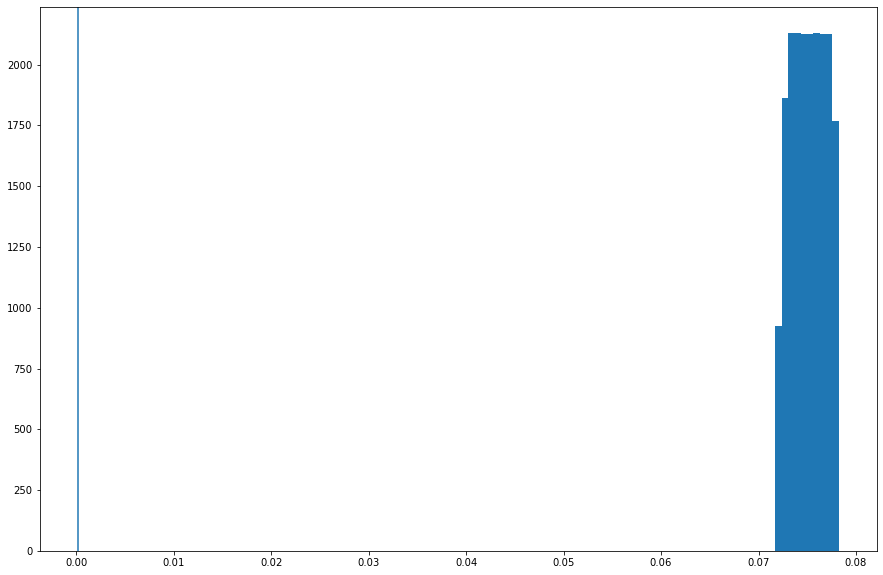

In [24]:
#plt.hist(df.delta_assim)
plt.hist(df.Integer_Cloud_Mask_dist)
plt.axvline(x = tolerance_spatial_dismatch / radii)

### OLD

### Reading MODIS

In [33]:
from osgeo import gdal

In [46]:
Cloud_file = 'data/MODIS_Aqua/MYD35_L2.A2020139.0305.061.2020139154430.hdf'
Cloud_file = 'data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf'

In [47]:
g = gdal.Open(Cloud_file)

In [ ]:
g.GetMetadata()

In [49]:
g.GetMetadata()["RANGEBEGINNINGDATE"]

'2020-05-18'

In [50]:
g.GetMetadata()["RANGEBEGINNINGTIME"]

'03:10:00.000000'

In [51]:
subdatasets = g.GetSubDatasets()
for fname, name in subdatasets:
    print(name)
    print("\t", fname)

[406x270] Scan_Start_Time mod35 (64-bit floating-point)
	 HDF4_EOS:EOS_SWATH:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":mod35:Scan_Start_Time
[406x270] Solar_Zenith mod35 (16-bit integer)
	 HDF4_EOS:EOS_SWATH:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":mod35:Solar_Zenith
[406x270] Solar_Azimuth mod35 (16-bit integer)
	 HDF4_EOS:EOS_SWATH:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":mod35:Solar_Azimuth
[406x270] Sensor_Zenith mod35 (16-bit integer)
	 HDF4_EOS:EOS_SWATH:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":mod35:Sensor_Zenith
[406x270] Sensor_Azimuth mod35 (16-bit integer)
	 HDF4_EOS:EOS_SWATH:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":mod35:Sensor_Azimuth
[2030x1354x2] Cloud_Mask_SPI mod35 (16-bit integer)
	 HDF4_EOS:EOS_SWATH:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":mod35:Cloud_Mask_SPI
[6x2030x1354] Cloud_Mask mod35 (8-bit integer)
	 HDF4_EOS:EOS_SWATH:"data/MOD

In [52]:
Cloud_file

'data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf'

In [53]:
name_Cloud_Mask_template = 'HDF4_EOS:EOS_SWATH:"%s":mod35:Cloud_Mask'
name_latitude_template   = 'HDF4_SDS:UNKNOWN:"%s":0'
name_longitude_template  = 'HDF4_SDS:UNKNOWN:"%s":1'
name_start_time_template = 'HDF4_SDS:UNKNOWN:"%s":2'


name_Cloud_Mask = name_Cloud_Mask_template % (Cloud_file)
name_latitude   = name_latitude_template % (Cloud_file)
name_longitude  = name_longitude_template % (Cloud_file)
name_start_time = name_start_time_template % (Cloud_file)

names_to_read = [name_Cloud_Mask,
                 name_latitude,
                 name_longitude,
                 name_start_time]

Cloud_data = {}

for name in names_to_read:

    g = gdal.Open( name )
    data = g.ReadAsArray()
    Cloud_data[name] = data

In [54]:
Cloud_data.keys()

dict_keys(['HDF4_EOS:EOS_SWATH:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":mod35:Cloud_Mask', 'HDF4_SDS:UNKNOWN:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":0', 'HDF4_SDS:UNKNOWN:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":1', 'HDF4_SDS:UNKNOWN:"data/MODIS_Aqua/MYD35_L2.A2020139.0310.061.2020139153854.hdf":2'])

### Time

In [55]:
f_t = Cloud_data[name_start_time]

In [62]:
f_t[1:5,1:5]

array([[8.63925011e+08, 8.63925011e+08, 8.63925011e+08, 8.63925011e+08],
       [8.63925013e+08, 8.63925013e+08, 8.63925013e+08, 8.63925013e+08],
       [8.63925013e+08, 8.63925013e+08, 8.63925013e+08, 8.63925013e+08],
       [8.63925014e+08, 8.63925014e+08, 8.63925014e+08, 8.63925014e+08]])

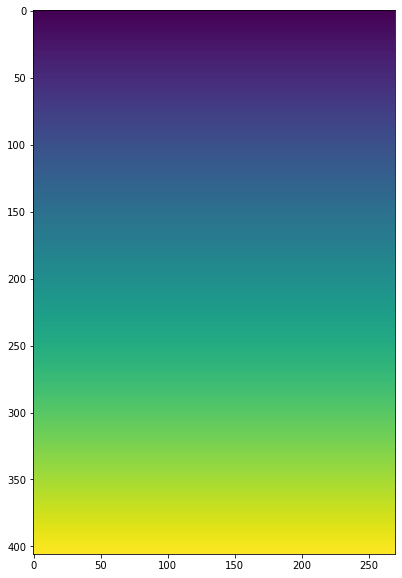

In [44]:
plt.imshow(f_t)

In [57]:
f_t.shape

(406, 270)

In [48]:
my_t = f_t[-1,-1]

from datetime import datetime
datetime.fromtimestamp(0)

start_date = datetime(1993,1,1,0,0,0,0)
start_date = datetime.timestamp(start_date)

my_t += start_date
my_t = datetime.fromtimestamp(my_t)

In [17]:
datetime(1993,1,1,0,0,0,0).year

1993

In [18]:
print(my_t)

2020-05-18 04:10:09.822242


In [19]:
modis_date(Cloud_file.split('/')[-1])

Timestamp('2020-05-18 03:05:00')

### Geolocation

In [21]:
latS = Cloud_data[name_latitude]
lonS = Cloud_data[name_longitude]

latS.shape

(406, 270)

In [30]:
lonS[0,-1]

89.155655

In [25]:
pairs = np.vstack( [latS.ravel(), lonS.ravel()] )

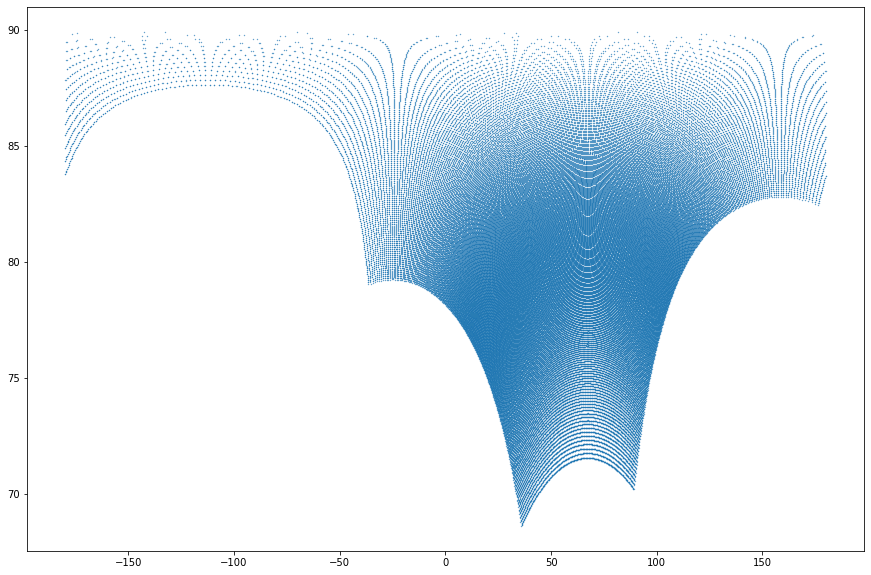

In [26]:
plt.scatter(pairs[1,:] , pairs[0,:], s = .1)

### Cloud Mask

In [27]:
extract = Cloud_data[name_Cloud_Mask]

In [28]:
extract

array([[[ 31,  31,  31, ..., 249, 249, 223],
        [ 31,  31,  31, ..., 249, 249, 249],
        [ 31,  31,  31, ..., 251, 249, 185],
        ...,
        [159, 159, 159, ..., 121, 121, 121],
        [159, 159, 159, ..., 249, 249, 249],
        [159, 159, 159, ..., 249, 249, 249]],

       [[144, 144, 144, ..., 143, 143, 134],
        [144, 144, 144, ..., 143, 143, 143],
        [144, 144, 144, ..., 142, 143, 143],
        ...,
        [144, 144, 144, ..., 137, 137, 137],
        [144, 144, 144, ..., 137, 137, 137],
        [144, 144, 144, ..., 137, 137, 137]],

       [[ 12,  12,  12, ...,  13,  13,  13],
        [ 12,  12,  12, ...,  13,  13,  13],
        [ 12,  12,  12, ...,  13,  13,  13],
        ...,
        [ 12,  12,  12, ...,   5,   5,   5],
        [ 12,  12,  12, ...,   5,   5,   5],
        [ 12,  12,  12, ...,   5,   5,   5]],

       [[  0,   0,   0, ...,  16,  16,   0],
        [  0,   0,   0, ...,  16,  16,  16],
        [  0,   0,   0, ...,  16,  16,  16],
        ..

In [30]:
modis_firstbyte = extract[0, :, :]

In [32]:
modis_firstbyte

array([[ 31,  31,  31, ..., 249, 249, 223],
       [ 31,  31,  31, ..., 249, 249, 249],
       [ 31,  31,  31, ..., 251, 249, 185],
       ...,
       [159, 159, 159, ..., 121, 121, 121],
       [159, 159, 159, ..., 249, 249, 249],
       [159, 159, 159, ..., 249, 249, 249]], dtype=uint8)

In [ ]:
extract.tobytes()

In [72]:
def extract_bit(number, bit):
    
    res = ''
    my_num = number
    
    for j in range(8):
        i = my_num % 2
        res = str(i) + res
        my_num = int( (my_num - i) / 2 )
        
    return int(res[bit])

extract_bit = np.vectorize(extract_bit)

In [73]:
modis_cloud_mask_flag = extract_bit(modis_firstbyte, 0)

In [76]:
np.unique(modis_cloud_mask_flag)

array([0, 1])

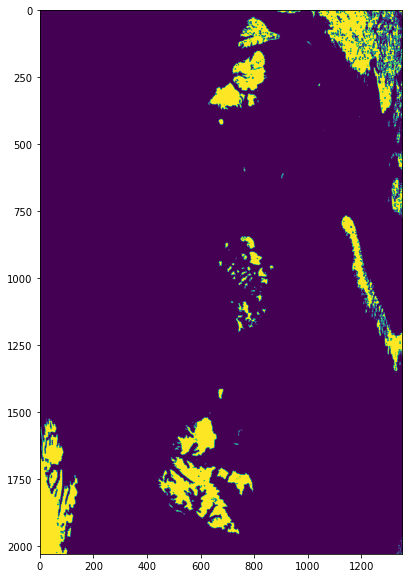

In [75]:
plt.imshow(modis_cloud_mask_flag)

### Cloud Mask Sub-product

    - how to read scan_start_time and how it it related to lat-lon

In [63]:
#Cloud_file = 'data/MODIS_Aqua/CLDMSK_L2_MODIS_Aqua.A2020139.1755.001.2020140163713.nc'
#Cloud_file = 'data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019218.1654.001.2019219010331.nc'
Cloud_file = 'data/VIIRS/CLDMSK_L2_VIIRS_SNPP.A2019267.1448.001.2019268010420.nc'

In [64]:
f_ = h5py.File(Cloud_file)     

<ipython-input-64-6516354e0cfa>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f_ = h5py.File(Cloud_file)


In [65]:
f_.keys()

<KeysViewHDF5 ['QA_dimension', 'byte_segment', 'geolocation_data', 'geophysical_data', 'number_of_lines', 'number_of_pixels', 'number_of_scans', 'scan_line_attributes']>

In [66]:
f_['number_of_scans']

<HDF5 dataset "number_of_scans": shape (203,), type ">f4">

In [67]:
f_t = f_['scan_line_attributes']['scan_start_time'][:]

In [68]:
f_t

array([8.43490090e+08, 8.43490092e+08, 8.43490094e+08, 8.43490096e+08,
       8.43490097e+08, 8.43490099e+08, 8.43490101e+08, 8.43490103e+08,
       8.43490104e+08, 8.43490106e+08, 8.43490108e+08, 8.43490110e+08,
       8.43490112e+08, 8.43490113e+08, 8.43490115e+08, 8.43490117e+08,
       8.43490119e+08, 8.43490120e+08, 8.43490122e+08, 8.43490124e+08,
       8.43490126e+08, 8.43490128e+08, 8.43490129e+08, 8.43490131e+08,
       8.43490133e+08, 8.43490135e+08, 8.43490136e+08, 8.43490138e+08,
       8.43490140e+08, 8.43490142e+08, 8.43490144e+08, 8.43490145e+08,
       8.43490147e+08, 8.43490149e+08, 8.43490151e+08, 8.43490152e+08,
       8.43490154e+08, 8.43490156e+08, 8.43490158e+08, 8.43490160e+08,
       8.43490161e+08, 8.43490163e+08, 8.43490165e+08, 8.43490167e+08,
       8.43490168e+08, 8.43490170e+08, 8.43490172e+08, 8.43490174e+08,
       8.43490176e+08, 8.43490177e+08, 8.43490179e+08, 8.43490181e+08,
       8.43490183e+08, 8.43490184e+08, 8.43490186e+08, 8.43490188e+08,
      

In [73]:
print(time_from_TAI93(f_t[1]))

2019-09-24 14:48:11.949509+00:00


In [74]:
viirs_date(Cloud_file.split('/')[-1])

Timestamp('2019-09-24 14:48:00')

In [75]:
203 * 16 

3248

In [112]:
f_['scan_line_attributes']['scan_start_time'][:].shape

(203,)

In [113]:
f_['geolocation_data'].keys()

<KeysViewHDF5 ['latitude', 'longitude', 'sensor_azimuth', 'sensor_zenith', 'solar_azimuth', 'solar_zenith']>

In [76]:
latS = f_['geolocation_data']['latitude'][:]
lonS = f_['geolocation_data']['longitude'][:]

In [77]:
latS.shape

(3248, 3200)

In [78]:
f_['geophysical_data']['Cloud_Mask'].shape

(6, 3248, 3200)

In [79]:
f_['geophysical_data']['Integer_Cloud_Mask'][:].shape

(3248, 3200)

In [96]:
pairs = np.vstack( [latS.ravel(), lonS.ravel()] )

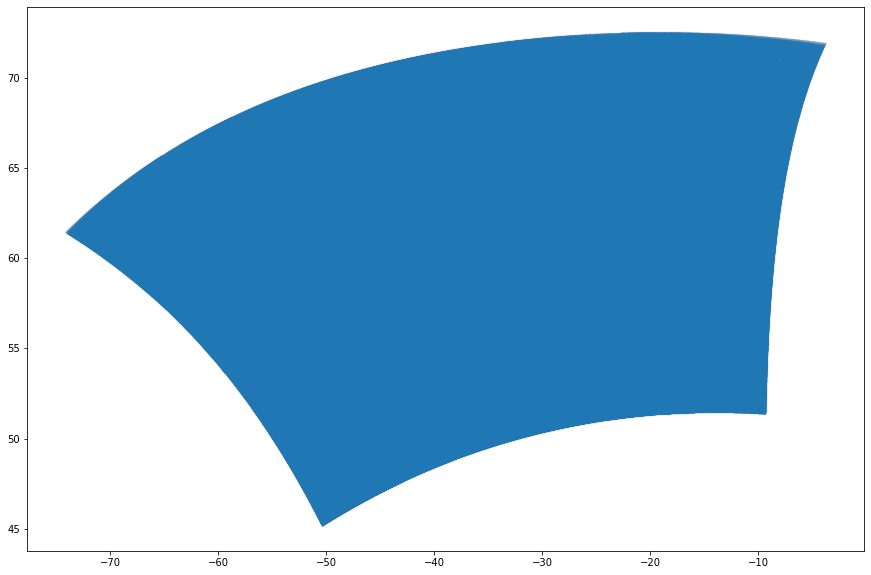

In [97]:
plt.scatter(pairs[1,:] , pairs[0,:], s = .001)

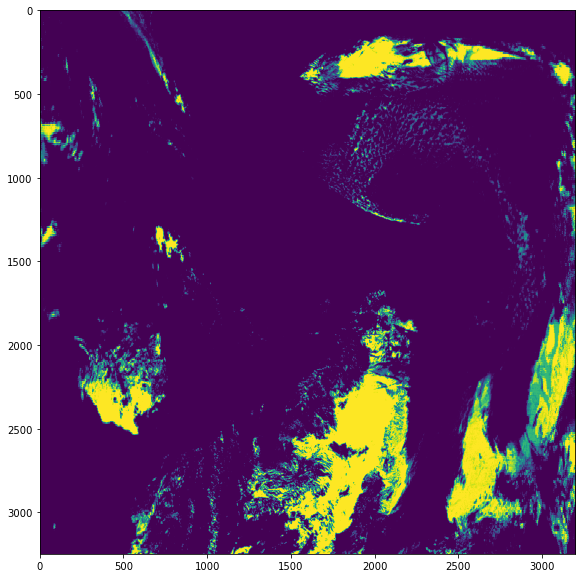

In [99]:
plt.imshow(f_['geophysical_data']['Integer_Cloud_Mask'][:])